In [1]:
import pandas as pd
import numpy as np

# Read the CSV file
df1 = pd.read_csv('normalized_dataset.csv')

# Get the number of columns
num_columns = len(df1.columns)

print("Number of columns in the CSV file:", num_columns)

# Read the CSV file
df2 = pd.read_csv('large-mergedDataset.csv')

# Get the number of columns
num_columns = len(df2.columns)

print("Number of columns in the CSV file:", num_columns)

Number of columns in the CSV file: 186
Number of columns in the CSV file: 15


In [2]:

# Merge the DataFrames based on 'id' column
merged_df = pd.merge(df1, df2, on='id')

# Print the shape of the merged DataFrame to confirm the merge was successful
print("Shape of merged DataFrame:", merged_df.shape)

merged_df.to_csv('merged_dataset.csv', index=False)



Shape of merged DataFrame: (19538, 200)


In [3]:
# Read the CSV file
df3 = pd.read_csv('merged_dataset.csv')

# Get the number of columns
num_columns = len(df3.columns)

print("Number of columns in the CSV file:", num_columns)

Number of columns in the CSV file: 200


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors

# Function to preprocess text
def preprocess_text(text):
    # Check if the text is NaN (handles missing values)
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove URLs and specific patterns (if any)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)

        # Remove punctuation and non-word characters
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back to a cleaned text
        cleaned_text = ' '.join(tokens)
    else:
        cleaned_text = ''  # Replace NaN with an empty string
    return cleaned_text

# Preprocess 'targetTitle' column and update it in the DataFrame
df3['targetTitle'] = df3['targetTitle'].apply(preprocess_text)

# Save the updated DataFrame to a new CSV file
df3.to_csv('preprocess_merged.csv', index=False)

# Print the shape of the preprocessed DataFrame
print("Shape of preprocessed DataFrame:", df3.shape)


Shape of preprocessed DataFrame: (19538, 200)


In [5]:
# Load the DataFrame with the preprocessed 'targetTitle' column
df4 = pd.read_csv('preprocess_merged.csv')

# Load GloVe word vectors
glove_path = 'glove.6B.100d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

# Function to get GloVe word embeddings
def get_glove_embeddings(text):
    words = text.split()
    embeddings = [glove_model[word] if word in glove_model else np.zeros(100) for word in words]
    if not embeddings:
        return np.zeros(100)  # Assign a default embedding for empty lists (out-of-vocabulary words)
    return np.mean(embeddings, axis=0)

# Apply GloVe embeddings to the preprocessed 'targetTitle' column
df4['targetTitle_glove'] = df3['targetTitle'].apply(get_glove_embeddings)

# Save the DataFrame with embeddings to a new CSV file
df4.to_csv('preprocess_merged_with_glove.csv', index=False)

# Print the shape of the DataFrame with GloVe embeddings
print("Shape of DataFrame with GloVe embeddings:", df4.shape)


Shape of DataFrame with GloVe embeddings: (19538, 201)


In [6]:

from sklearn.model_selection import train_test_split

# Load the preprocess_merged.csv file
df5 = pd.read_csv('preprocess_merged_with_glove.csv')

# Separate features (X) and class labels (Y)
X = df5["targetTitle_glove"]
Y = df5["truthClass"]
ids = df5["id"]

from keras.utils.np_utils import to_categorical
classes_list = ["no-clickbait","clickbait"]
label_index = Y.apply(classes_list.index)
label1 = np.asarray(label_index)
label = to_categorical(np.asarray(label1))
y=label1
y.shape
y

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [7]:


# Perform train-test split on X, Y, and ids
X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(X, Y, ids, test_size=0.2, random_state=42)
X_dev, X_train, y_dev, y_train, ids_dev, ids_train = train_test_split(X_temp, y_temp, ids_temp, test_size=0.5, random_state=42)

# Create DataFrames for X_train, X_dev, and X_test including 'id'
X_train_df = df5[df5["id"].isin(ids_train)]
X_dev_df = df5[df5["id"].isin(ids_dev)]
X_test_df = df5[df5["id"].isin(ids_test)]

# Create DataFrames for y_train, y_dev, and y_test including 'id'
y_train_df = df5[df5["id"].isin(ids_train)]
y_dev_df = df5[df5["id"].isin(ids_dev)]
y_test_df = df5[df5["id"].isin(ids_test)]

# Save DataFrames to CSV files including 'id'
X_train_df.to_csv('X_train.csv', index=False)
X_dev_df.to_csv('X_dev.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)

y_train_df.to_csv('y_train.csv', index=False)
y_dev_df.to_csv('y_dev.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)


In [8]:


# Load the preprocessed DataFrame with GloVe embeddings
X_dev_df = pd.read_csv('X_dev.csv')

# Extract the 'targetTitle_glove' column as a numpy array
targetTitle_glove_values = np.array(X_dev_df['targetTitle_glove'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).tolist())

# Get the value of the first row of 'targetTitle_glove'
first_row_value = targetTitle_glove_values[1]

print("Value of the first row of 'targetTitle_glove':")
print(first_row_value.shape)


Value of the first row of 'targetTitle_glove':
(100,)


In [9]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

# Load the preprocessed DataFrame with GloVe embeddings
df5 = pd.read_csv('preprocess_merged_with_glove.csv')

# Load the preprocessed 'X_dev' DataFrame with 'targetTitle_glove' column
X_dev_df = pd.read_csv('X_dev.csv')
X_dev_glove = np.array(X_dev_df['targetTitle_glove'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).tolist())


# Assuming 'targetTitle_glove' has a size of 100 (embedding dimension)
input_dim = 100

# Define the autoencoder architecture
def build_autoencoder(input_dim, bottleneck_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(100, activation='relu')(input_layer)
    encoded = Dense(75, activation='relu')(encoded)
    bottleneck = Dense(bottleneck_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(75, activation='relu')(bottleneck)
    decoded = Dense(100, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Build the autoencoder
bottleneck_dim = 50
autoencoder = build_autoencoder(input_dim, bottleneck_dim)

# Train the autoencoder
autoencoder.fit(X_dev_glove, X_dev_glove, epochs=50, batch_size=32, validation_split=0.1)

# Display the summary of the autoencoder model
autoencoder.summary()



Epoch 1/50
220/220 [==============================] - 1s 3ms/step - loss: 0.0391 - val_loss: 0.0277
Epoch 2/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0220
Epoch 3/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0196
Epoch 4/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0185 - val_loss: 0.0184
Epoch 5/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 6/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0167 - val_loss: 0.0168
Epoch 7/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 8/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 9/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 10/50
220/220 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0160

In [10]:

# Load the trained autoencoder model (after the training step)
autoencoder = build_autoencoder(input_dim, bottleneck_dim)

# Get the encoder part of the autoencoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)

# Obtain the encoded representations of X_dev
encoded_X_dev = encoder.predict(X_dev_glove)

print("Encoded representations (compressed embeddings) of X_dev:")
print(encoded_X_dev)


245/245 [==============================] - 0s 750us/step
Encoded representations (compressed embeddings) of X_dev:
[[0.         0.         0.05626149 ... 0.         0.         0.02374446]
 [0.         0.         0.02676193 ... 0.         0.04817724 0.        ]
 [0.         0.02883859 0.1345847  ... 0.         0.         0.02021736]
 ...
 [0.         0.02883021 0.22144365 ... 0.         0.         0.02675472]
 [0.         0.06564091 0.11847187 ... 0.         0.01194718 0.        ]
 [0.         0.         0.04233793 ... 0.         0.         0.        ]]


In [11]:

import json


# Save the autoencoder weights to a JSON file
autoencoder.save_weights('autoencoder_weights.h5')
with open('autoencoder_summary.json', 'w') as f:
    json.dump(autoencoder.summary(), f)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 75)                7575      
                                                                 
 dense_8 (Dense)             (None, 50)                3800      
                                                                 
 dense_9 (Dense)             (None, 75)                3825      
                                                                 
 dense_10 (Dense)            (None, 100)               7600      
                                                                 
 dense_11 (Dense)            (None, 100)               1010

In [12]:


# Load the preprocessed DataFrame with GloVe embeddings and the corresponding IDs
X_train_df = pd.read_csv('X_train.csv')
X_test_df = pd.read_csv('X_test.csv')

# Extract the 'id' column from the DataFrames
X_train_ids = X_train_df['id']
X_test_ids = X_test_df['id']

# Convert 'targetTitle_glove' column into numpy arrays for X_train and X_test
X_train_glove = np.array(X_train_df['targetTitle_glove'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).tolist())
X_test_glove = np.array(X_test_df['targetTitle_glove'].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).tolist())


# Load the trained autoencoder model (after the training step)
autoencoder = build_autoencoder(input_dim + 1, bottleneck_dim)  # Add 1 for the 'class label' column

# Get the encoder part of the autoencoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)

# Concatenate 'targetTitle_glove' with 'class label' columns for X_train and X_test
X_train_combined = np.hstack((X_train_glove, np.array(X_train_df['class label']).reshape(-1, 1)))
X_test_combined = np.hstack((X_test_glove, np.array(X_test_df['class label']).reshape(-1, 1)))

# Obtain the encoded representations of X_train_combined and X_test_combined
encoded_X_train_combined = encoder.predict(X_train_combined)
encoded_X_test_combined = encoder.predict(X_test_combined)

# Extract 50 features from the bottleneck layer for X_train_combined and X_test_combined
extracted_features_X_train = encoded_X_train_combined[:, :50]
extracted_features_X_test = encoded_X_test_combined[:, :50]

# Create DataFrames for extracted features including 'id' column
X_train_features_df = pd.DataFrame(data=np.hstack((X_train_ids.values.reshape(-1, 1), extracted_features_X_train)),
                                   columns=['id'] + [f'feature_{i+1}' for i in range(50)])

X_test_features_df = pd.DataFrame(data=np.hstack((X_test_ids.values.reshape(-1, 1), extracted_features_X_test)),
                                  columns=['id'] + [f'feature_{i+1}' for i in range(50)])

# Save the extracted features to CSV files
X_train_features_df.to_csv('X_train_features.csv', index=False)
X_test_features_df.to_csv('X_test_features.csv', index=False)


123/123 [==============================] - 0s 768us/step


In [13]:
#Load the datasets
X_train = pd.read_csv('X_train.csv')
X_train_features = pd.read_csv('X_train_features.csv')

# Select the specified columns from X_train DataFrame
selected_columns = ['sim between postText and Title',
                    'Pt_Readability of postText',
                    'Paragraph Ratio of formal and informal word',
                    'entroy',
                    'class label',
                    'id']
selected_features = X_train[selected_columns]

# Merge the selected features with X_train_features DataFrame based on 'id'
X_train_final = pd.merge(X_train_features, selected_features, on='id')

#Save the merged DataFrame as a new CSV file
X_train_final.to_csv('X_train_final.csv', index=False)


In [14]:
#Load the datasets
X_test = pd.read_csv('X_test.csv')
X_test_features = pd.read_csv('X_test_features.csv')

#Select the specified columns from X_test DataFrame
selected_columns = ['sim between postText and Title',
                    'Pt_Readability of postText',
                    'Paragraph Ratio of formal and informal word',
                    'entroy',
                    'class label',
                    'id']
selected_features = X_test[selected_columns]

#Merge the selected features with X_test_features DataFrame based on 'id'
X_test_final = pd.merge(X_test_features, selected_features, on='id')

#Save the merged DataFrame as a new CSV file
X_test_final.to_csv('X_test_final.csv', index=False)


In [15]:
# Load the training and testing datasets
X_train_final = pd.read_csv('X_train_final.csv')
X_test_final = pd.read_csv('X_test_final.csv')

# Extract features (X) and labels (y)
y_train = X_train_final['class label']
y_test = X_test_final['class label']
col_drop=['id', 'class label']
X_train = X_train_final.drop(col_drop, axis=1)
X_test = X_test_final.drop(col_drop, axis=1)



In [16]:
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC
    from sklearn import metrics
    from sklearn.svm import SVC
    model_SVM = SVC()
    model_SVM.fit(X_train, y_train)
    y_pred_SVM = model_SVM.predict(X_test)
    print("SVM")
    print(metrics.classification_report(y_test, y_pred_SVM))
    print(confusion_matrix(y_test, y_pred_SVM))


    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    y_pred_rf = rf.predict(X_test)
    print("random")
    print(metrics.classification_report(y_test, y_pred_rf))
    print(confusion_matrix(y_test, y_pred_rf))

    from sklearn.linear_model import LogisticRegression
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    y_pred_LR = LR.predict(X_test)
    print("Logistic Regression")
    print(metrics.classification_report(y_test, y_pred_LR ))
    print(confusion_matrix(y_test, y_pred_LR))

    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier()
    neigh.fit(X_train,y_train)
    y_pred_KNN = neigh.predict(X_test)
    print("KNN")
    print(metrics.classification_report(y_test, y_pred_KNN ))
    print(confusion_matrix(y_test, y_pred_KNN))

    from sklearn.naive_bayes import GaussianNB
    naive = GaussianNB()
    naive.fit(X_train,y_train)
    y_pred_naive = naive.predict(X_test)
    print("Naive Bayes")
    print(metrics.classification_report(y_test, y_pred_naive ))
    print(confusion_matrix(y_test, y_pred_naive))

    from sklearn.ensemble import GradientBoostingClassifier
    gradient = GradientBoostingClassifier()
    gradient.fit(X_train,y_train)
    y_pred_gradient = gradient.predict(X_test)
    print("Gradient Boosting")
    print(metrics.classification_report(y_test, y_pred_gradient ))
    print(confusion_matrix(y_test, y_pred_gradient))

    from sklearn.tree import DecisionTreeClassifier
    decision = DecisionTreeClassifier()
    decision.fit(X_train,y_train)
    y_pred_decision = decision.predict(X_test)
    print("Decision Tree")
    print(metrics.classification_report(y_test, y_pred_decision ))
    print(confusion_matrix(y_test, y_pred_decision))

    from sklearn.ensemble import AdaBoostClassifier
    AdaBoostclf = AdaBoostClassifier()
    AdaBoostclf.fit(X_train,y_train)
    y_pred_AdaBoostclf = AdaBoostclf.predict(X_test)
    print("AdaBoost classifier")
    print(metrics.classification_report(y_test, y_pred_AdaBoostclf ))
    print(confusion_matrix(y_test, y_pred_AdaBoostclf))

SVM
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1801
           1       0.78      0.53      0.63       587

    accuracy                           0.85      2388
   macro avg       0.82      0.74      0.77      2388
weighted avg       0.84      0.85      0.84      2388

[[1714   87]
 [ 277  310]]
random
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1801
           1       0.79      0.52      0.63       587

    accuracy                           0.85      2388
   macro avg       0.82      0.74      0.77      2388
weighted avg       0.84      0.85      0.84      2388

[[1718   83]
 [ 279  308]]
Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      1801
           1       0.74      0.48      0.59       587

    accuracy                           0.83      2388
   macro avg       0.80      0.71      0.74

C:\Users\nites\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN
              precision    recall  f1-score   support

           0       0.86      0.94      0.89      1801
           1       0.72      0.52      0.60       587

    accuracy                           0.83      2388
   macro avg       0.79      0.73      0.75      2388
weighted avg       0.82      0.83      0.82      2388

[[1686  115]
 [ 284  303]]
Naive Bayes
              precision    recall  f1-score   support

           0       0.93      0.12      0.22      1801
           1       0.27      0.97      0.42       587

    accuracy                           0.33      2388
   macro avg       0.60      0.55      0.32      2388
weighted avg       0.77      0.33      0.27      2388

[[ 224 1577]
 [  17  570]]
Gradient Boosting
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1801
           1       0.79      0.58      0.67       587

    accuracy                           0.86      2388
   macro avg       0.83      0.76      0

In [17]:

from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten
from sklearn import metrics
from keras.layers import Dense,Input,Dropout, concatenate,Concatenate
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np
from keras.utils.np_utils import to_categorical

def plot_AUC_ROC(y_true, y_pred):
    y_true = to_categorical(y_true)
    y_pred = to_categorical(y_pred)
    n_classes = y_true.shape[1]
    #n_classes = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
############################################################################################
    lw = 2
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()

    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    #classes_list1 = ["DE","NE","DK"]
    classes_list1 = ['Non-Clickbait', 'Clickbait']
    for i, color,c in zip(range(n_classes), colors,classes_list1):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='{0} (AUC = {1:0.2f})'
                ''.format(c, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    

In [18]:
classes = ["no-clickbait", "clickbait"]

# SVM

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


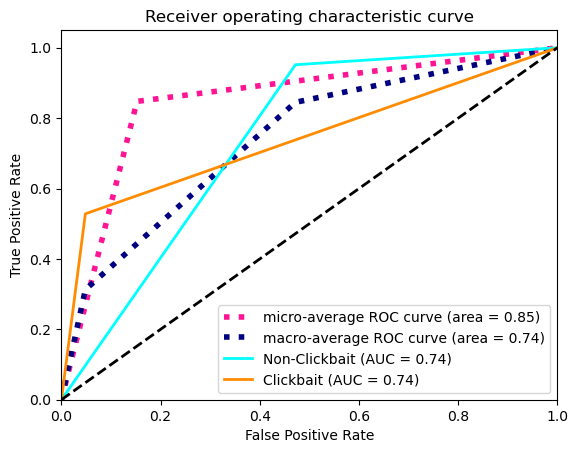

In [19]:
plot_AUC_ROC(y_test, y_pred_SVM)

Normalized confusion matrix
[[0.9516935  0.0483065 ]
 [0.47189097 0.52810903]]


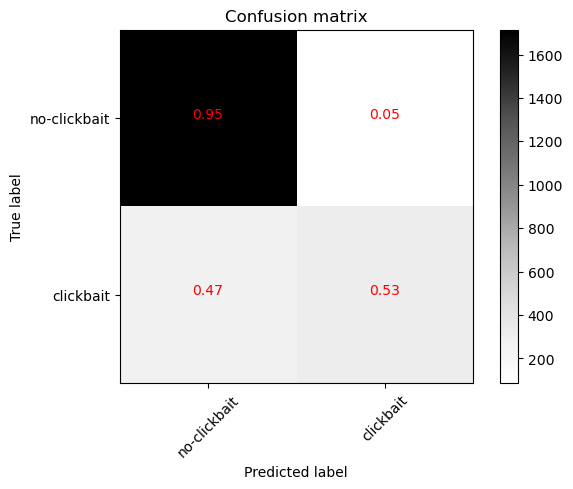

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_SVM),classes)


# Random forest classifier

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


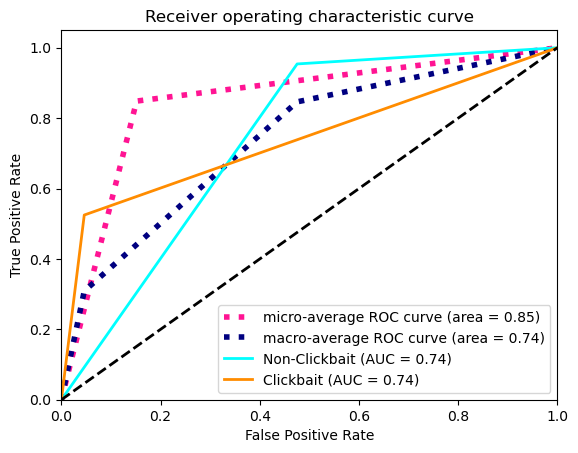

In [21]:
plot_AUC_ROC(y_test, y_pred_rf)

Normalized confusion matrix
[[0.95391449 0.04608551]
 [0.47529813 0.52470187]]


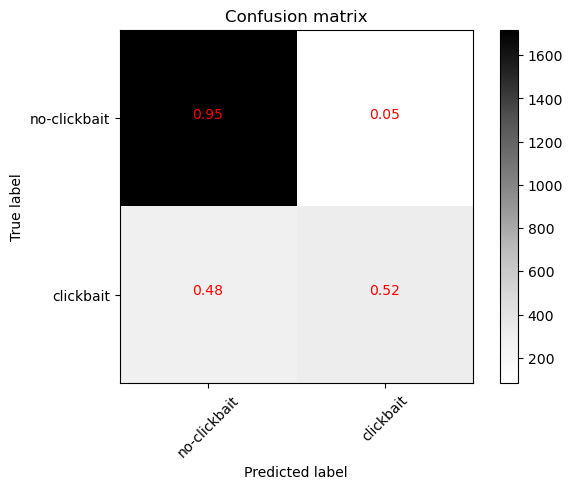

In [22]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf),classes)

# Logistic regression

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


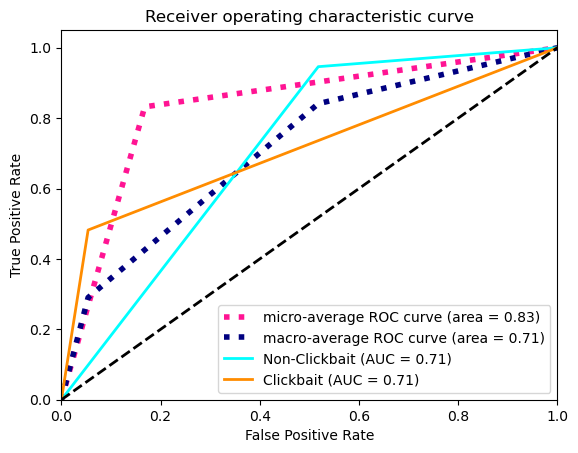

In [23]:
plot_AUC_ROC(y_test, y_pred_LR)

Normalized confusion matrix
[[0.94614103 0.05385897]
 [0.51788756 0.48211244]]


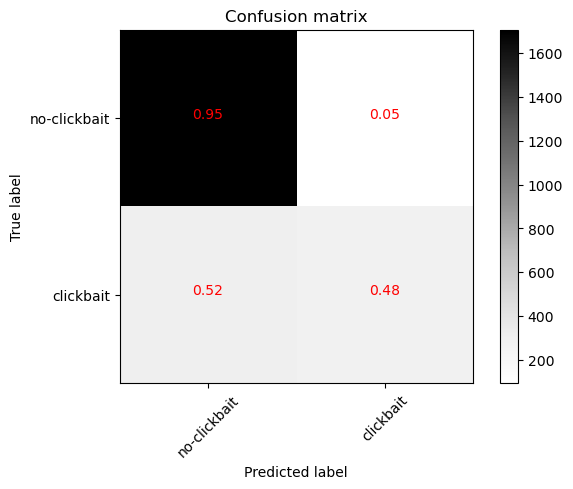

In [24]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_LR),classes)

# KNN

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


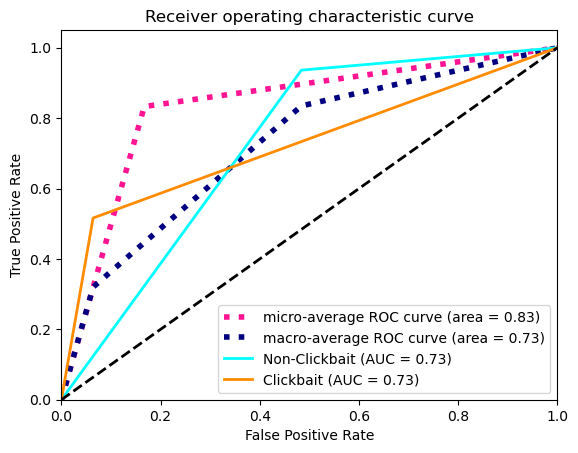

In [25]:
plot_AUC_ROC(y_test, y_pred_KNN)

Normalized confusion matrix
[[0.93614659 0.06385341]
 [0.48381601 0.51618399]]


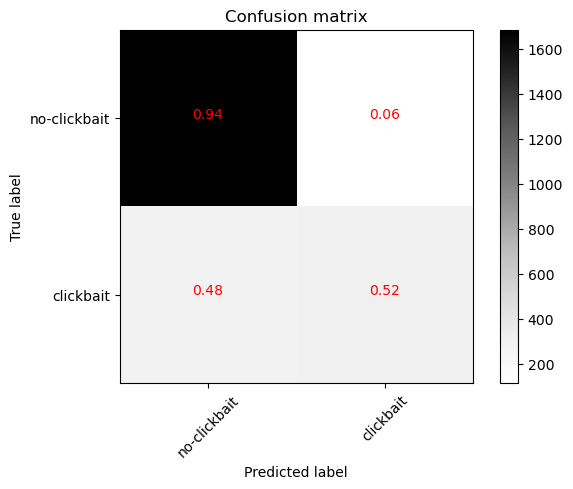

In [26]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_KNN),classes)

# Naive Bayes

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


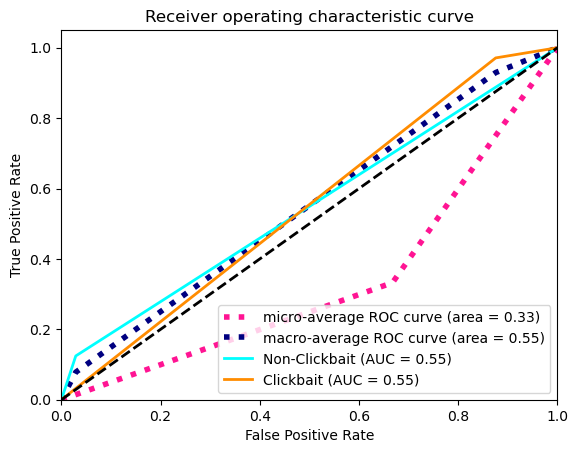

In [27]:
plot_AUC_ROC(y_test, y_pred_naive)

Normalized confusion matrix
[[0.12437535 0.87562465]
 [0.02896082 0.97103918]]


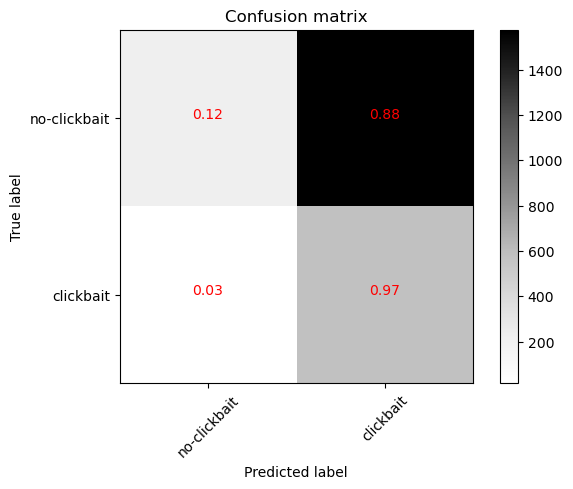

In [28]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred_naive), classes)

# Gredient boosting

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


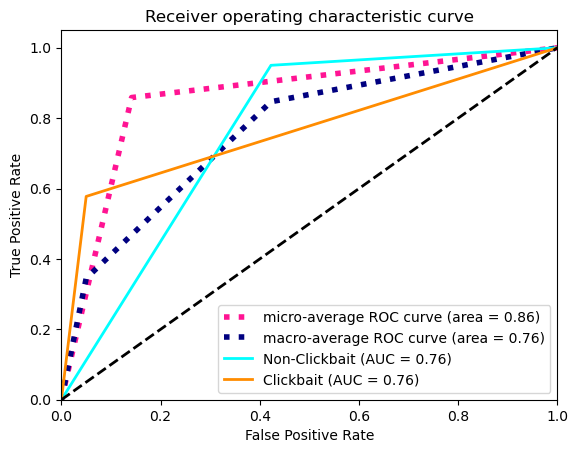

In [29]:
plot_AUC_ROC(y_test, y_pred_gradient)

Normalized confusion matrix
[[0.95002776 0.04997224]
 [0.42248722 0.57751278]]


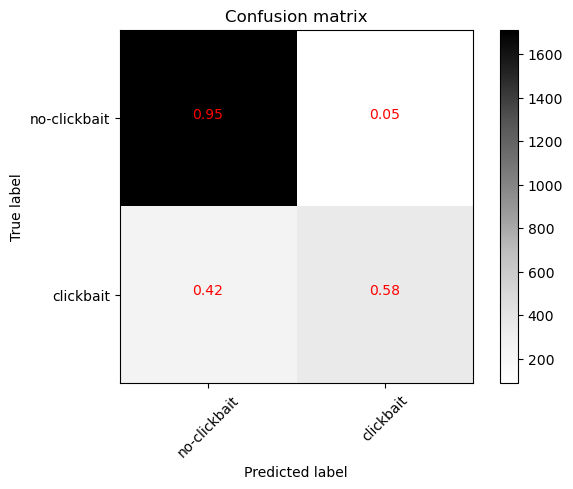

In [30]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_gradient),classes)

# Decision Tree

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


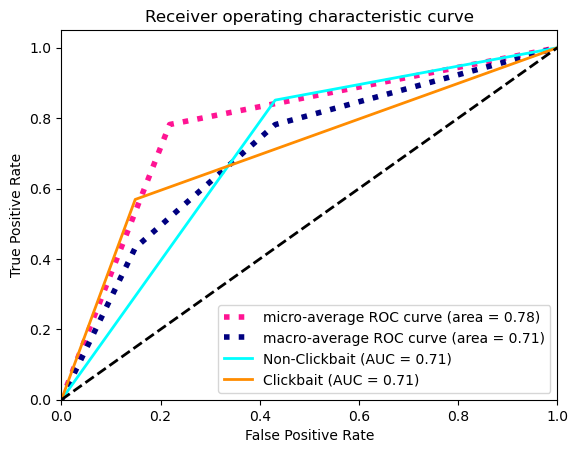

In [31]:
plot_AUC_ROC(y_test, y_pred_decision)

Normalized confusion matrix
[[0.85119378 0.14880622]
 [0.43100511 0.56899489]]


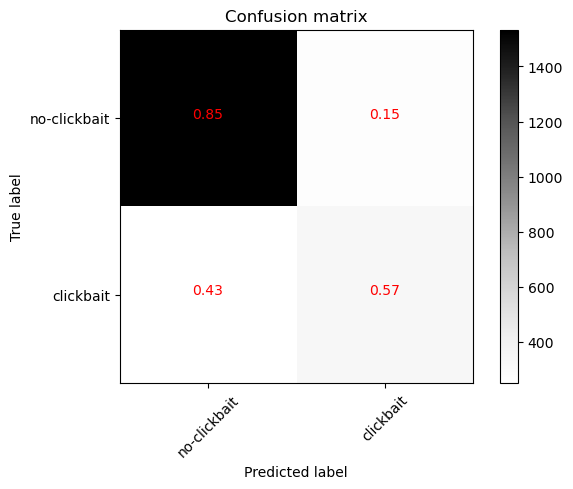

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_decision), classes)

# Adaboot Classifier

C:\Users\nites\AppData\Local\Temp\ipykernel_22932\1546159797.py:91: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


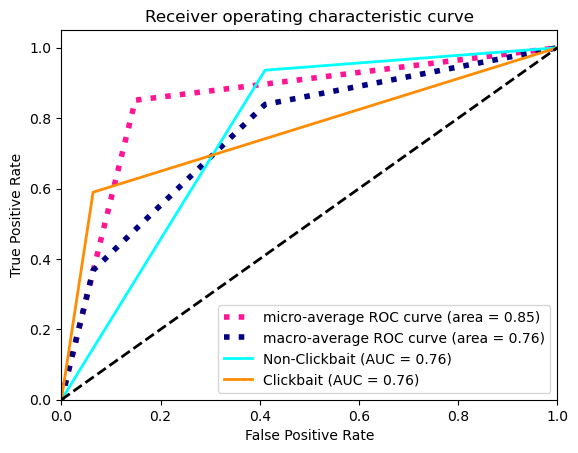

In [33]:
plot_AUC_ROC(y_test, y_pred_AdaBoostclf)

Normalized confusion matrix
[[0.93614659 0.06385341]
 [0.41056218 0.58943782]]


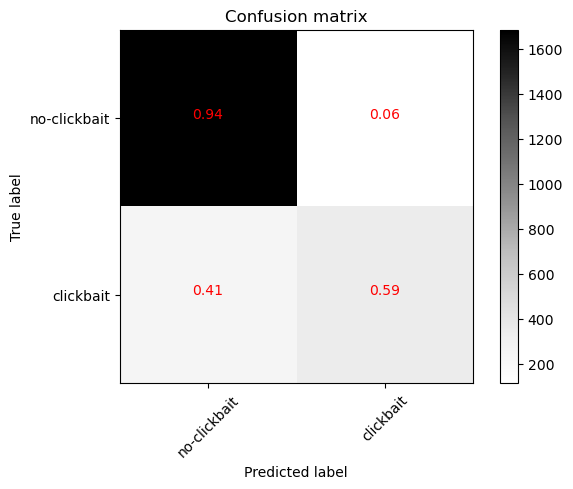

In [34]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_AdaBoostclf), classes)